## Astro 304 "Galaxies"

### Morphology and properties of galaxy light distribution

You can turn this notebook into a slide show using nbconvert package:

jupyter-nbconvert --to slides ex04_sdss_morphology.ipynb --post serve

In [1]:
# preliminaries to set up work space
import numpy as np

# setup notebook for inline figures
%matplotlib inline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

# allow automatic reload of imported codes, if they are modified
%load_ext autoreload
%autoreload 2

### The UPenn version of the SDSS catalog

In what follows, as well as for homework 2 assignment, we will use a different version of the SDSS spectroscopic catalog: the <a href="http://www.physics.upenn.edu/~ameert/SDSS_PhotDec/download/">UPenn catalogs</a> with their model photometry fits to the SDSS DR7 main galaxy sample (<a href="http://adsabs.harvard.edu/abs/2015MNRAS.446.3943M">Meert et al. 2015</a>). The catalog files are available in the data/ directory shared with you previously, which can be found  <a href="http://astro.uchicago.edu/~andrey/classes/a304s18/data/">here</a> in the subdirectory <tt>data/Meert2015_v2/</tt>. The file <tt>data_tables</tt> in this subdirectory contains description of the information contained in the catalog (some of it is duplicates from the SDSS catalogs, but much of it is new). Unlike, previous dataset the UPenn catalog comes as a collection of FITS files. I provide a routine for reading them and you can find example code below that shows how the catalog is read and how some cuts are applied to derive a clean sample of galaxies. 

The switch to a different version is for 2 reasons:

<b>1)</b> the catalog contains many additional useful properties of galaxies, such as good morphological classifications based on the method of Huertas-Company et al. (2011). The probability of a given morphological type for each galaxy will be used below in a number of illustrations. 

<b>2)</b> most importantly, this catalog contains much more accurate photometry of bright galaxies compared to the standard SDSS catalog. This means better estimates of luminosity and sizes of galaxies, among other things. The latter will be important for measuring the luminosity function of galaxies correctly and for plotting other galaxy properties.

However, because it relied on ability of the photometric pipeline to fit more sophisticated models for the radial distribution of surface brightness to get luminosity, this catalog does not extend to as high $z$ as the SDSS main spectroscopic sample. Most galaxies in the UPenn catalog are at $z\leq 0.2$. 

In [2]:
#import routine that reads SDSS catalog with photometry from Meert et al
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  
# 1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = ((vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) 
        & (sb50 > 0.) & (sb50 <= 25.) & (grm>-0.5) & (grm<2.2))

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print("selected %d galaxies after all cuts"%np.size(zm))

# luminosity distance in Mpc
from code.cosmology import d_l

Om0 = 0.3; OmL = 0.7
h = 0.7 # H0/100
d_H = 2997.92 # c/(100 km/s/Mpc) 

d_Lm = d_l(zm, Om0, OmL, ninter=20)

# dimensionless distance -> /h Mpc 
d_Lm *= d_H / h

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# inverse Vmax. In this catalog pre-computed Vmax is provided 
#vmaxi = 1.0/vmaxm[ilim]/3.0

d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
ccm = 0.93

# 0.195 is the fraction of total sky solid angle that is covered by the UPenn photometric catalog, 
# as reported by them
solid_anglem = 4.*np.pi/3*0.195
# 1/Vmax
vmaxim = vmaxim / (solid_anglem*ccm)

# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; 
pSab = morph['probaSab']; pScd = morph['probaScd']; 


670722 galaxies in Meert et al. sample initially
selected 245197 galaxies after all cuts


Here is how you can check the fields contained in the data tables. You can cross-reference these variable names with the info in the <tt>data/Meert2015_v2/data_tables.pdf</tt> file in the catalog subdirectory. 

In [3]:
print(mdata.names)

['m_tot', 'm_aper', 'BT', 'r_tot', 'ba_tot', 'BT_aper', 'xctr_bulge', 'xctr_bulge_err', 'yctr_bulge', 'yctr_bulge_err', 'm_bulge', 'm_bulge_err', 'r_bulge', 'r_bulge_err', 'n_bulge', 'n_bulge_err', 'ba_bulge', 'ba_bulge_err', 'pa_bulge', 'pa_bulge_err', 'xctr_disk', 'xctr_disk_err', 'yctr_disk', 'yctr_disk_err', 'm_disk', 'm_disk_err', 'r_disk', 'r_disk_err', 'n_disk', 'n_disk_err', 'ba_disk', 'ba_disk_err', 'pa_disk', 'pa_disk_err', 'GalSky', 'GalSky_err', 'chi2nu', 'finalflag', 'autoflag', 'pyflag', 'pyfitflag']


### Meert et al catalog surface brightness models 

We can see that the info here is almost entirely different from what we saw previously in the table obtained from the SDSS server. 

In particular, <tt>m_tot</tt> is total apparent magnitude measured by photometric model of Meert et al. (2015). Different versions of photometry adopt different model for surface brightness profile of galaxies. 

Model 2 uses De Vaucouleurs profile for all galaxies. Model 3 uses Sersic profile for all galaxies with Sersic index as an additional free parameter in addition to profile normalization and half-light radius. Models 4 and 5 use 2-component profile model: model 4 fits De Vaucoulers+exponential profile and model 5 fits Sersic+exponential profile. 

If model 1 is specified than for each galaxy photometry is using a model from 2-5 that best fits this particular galaxy. 

As mentioned before, Sersic surface brightness model is a generalization of the exponential and De Vaucouleurs profiles. 

### Sersic surface brightness/density profile

The Sersic profile is sometimes expressed as
$$
\Sigma(R)=\Sigma_0\exp\left[-\left(\frac{R}{R_d}\right)^{1/n}\right],
$$

When expressed using the *effective radius* $R_e$ that encloses half of the total light of the profile, the form is
<br>
$$
\Sigma(R)=\Sigma_e\exp\left\{-b_n\left[\left(\frac{R}{R_e}\right)^{1/n}-1\right]\right\},
$$
where $\Sigma_e$ is the surface brightness at the effective radius $R_e$; it is related to $\Sigma_0$ via $\Sigma_0=\Sigma_e \exp(b_n)$, while radii are related via $R_d\equiv R_e/b_n^n$.

The constant $b_n$ is related to $n$ -- the S\'ersic index -- that controls the overall shape of the profile.  The constant is determined by solving equation for $R_e$ numerically for a given $n$, similarly how this was done for exponential and De Vaucouleurs profile before. An accurate approximation is given by $b_n = 1.9992n - 0.3271$. 

$n$ is given in the above catalog as <tt>n_tot</tt> when profile is fit by single Sersic component (model 3), or as <tt>n_bulge</tt> and <tt>n_disk</tt> for 2-component models (model 4 or 5). 

If profiles are constructed using magnitudes rather than surface brightness or intensity, the corresponding expression is:  
$$
\mu(R)=\mu_e+\frac{2.5b_n}{\ln(10)}\left[\left(\frac{R}{R_e}\right)^{1/n}-1\right].
$$


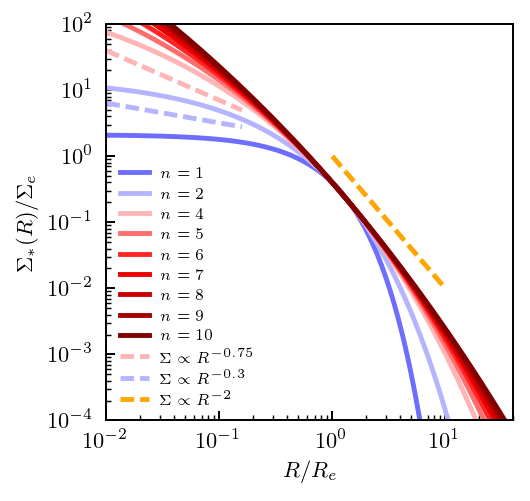

In [4]:
import matplotlib.cm as cm
import matplotlib.colors as colors

fig = plt.figure(figsize=(3, 3))

plt.xlabel ('$R/R_e$')
plt.ylabel (r'$\Sigma_{*}(R)/\Sigma_e$')

plt.xlim(0.01, 40.); plt.ylim(0.0001, 100.)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=10)

x = np.linspace(-2., 1.7, 200)
x = np.power(10.,x)
me = 1.0; Re=1.0

cnorm  = colors.Normalize(vmin=1, vmax=15)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.seismic)

# constract surface brightness profiles
for n in range(1,11,1):
    bn = 1.9992*n-0.3271
    spro = np.power(10.0,-0.4*(me + 2.5*bn*(np.power(x/Re,1.0/n)-1.0)/np.log(10.)))
    color = scalarmap.to_rgba(n+5)
    if n != 3: plt.plot(x,spro,'-', c=color, lw=2.0, label='$n=%i$'%n)

# plot power law for comparison:
x1 = np.linspace(-2., -0.8, 5); x2 = np.linspace(0., 1., 5)
x1 = np.power(10.,x1); x2 = np.power(10.,x2)
y1 = 1.6*np.power(x1,-.3); y2 = 1.*np.power(x2,-2.0)
y3 = 1.25*np.power(x1,-0.75)
#
color = scalarmap.to_rgba(4+5)
plt.plot(x1,y3,'--', c=color, lw=2.0, label=r'$\Sigma\propto R^{-0.75}$')
color = scalarmap.to_rgba(2+5)
plt.plot(x1,y1,'--', c=color, lw=2.0, label=r'$\Sigma\propto R^{-0.3}$')
plt.plot(x2,y2,'--', c='orange', lw=2.0, label=r'$\Sigma\propto R^{-2}$')

plt.legend(loc='lower left', frameon=False, fontsize=6)
#plt.title('Sersic profiles')
#plt.grid()
plt.savefig('fig/sersic_pro.png', bbox_inches='tight')
plt.show()


### Sersic profile for different $n$

<img width=500 align=left src="fig/sersic_pro.png"></img>

### Why the proliferation of profile models? 

Profiles of real galaxies are often more complicated than simple exponential or De Vaucouleurs profile (e.g., see profiles in Fig 1.4 of my notes), so model profiles must have more flexibility. 

This is achieved either by introducing extra parameter (Sersic index) or by introducing 2 or more components of different functional form to model the profile. 

### Using morphology probabilities in the Meert catalog 

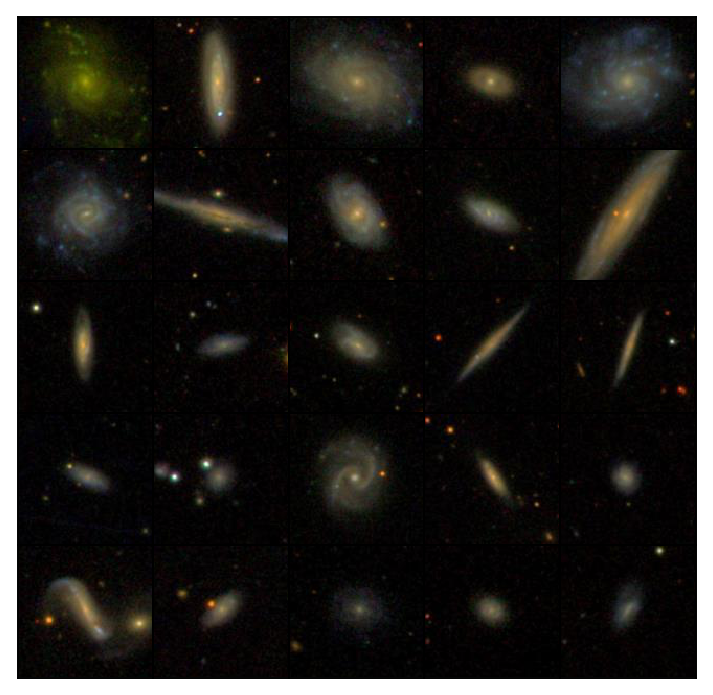

In [5]:
from code.plot_utils import sdss_img_collage

# the number of rows and columns in the image collage
nrow = 5; ncol = 5
# pixel size of the thumbnails to extract from the SDSS
npix = 130

# minimum and maximum luminosity distances for galaxy selection
Dmin = 20.; Dmax = 200.; 
# absolute magnitude limit on the faint end
Mlim = -19.0
Pmorphlim = 0.7

# select galaxies with these distance and absolute magnitude limits
MDsel = (Mmeert < Mlim) & (d_Lm > Dmin) & (d_Lm < Dmax)
#morphsel = (pEll>Pmorphlim) & (pEll>pS0) & (pEll>pSab) & (pEll>pScd) 
#morphsel  = ((pS0>Pmorphlim) & (pS0>pEll) & (pS0>pSab) & (pS0>pScd))
#morphsel = ((pSab>Pmorphlim) & (pSab>pEll) & (pSab>pS0) & (pSab>pScd))
morphsel = ((pScd>Pmorphlim) &(pScd>pEll) & (pScd>pS0) & (pScd>pSab))

rdata = sdata[MDsel & morphsel]

# select a random subset of galaxies from the selected subset
iran = np.unique(np.random.randint(0, np.size(rdata)-1, 2*nrow*ncol))

# get data for the randomly selected galaxies
dshow = rdata[iran]
objs = dshow['objid']; ras = dshow['ra']; decs = dshow['dec']
Dlshow = d_l(dshow['z'], Om0, OmL) * d_H / h
Dorder = Dlshow.argsort()

# get images (if they are not yet on disk) and display the collage 
sdss_img_collage(objs[Dorder], ras[Dorder], decs[Dorder], nrow, ncol, npix, scale=0.5, 
                 savefig='fig/pScd_gt_0.7_collage.png')
#sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.5, savefig='fig/pScd_gt_0.7_collage.png')

### Galaxies with $p_{\rm Ell}>0.7$  at $d_L<200$ Mpc

<img width=700 align=left src="fig/pEll_gt_0.7_collage.PNG"></img>

### Galaxies with $p_{\rm S0}>0.7$  at $d_L<200$ Mpc

<img width=700 align=left src="fig/pS0_gt_0.7_collage.PNG"></img>

### Galaxies with $p_{\rm Sab}>0.7$ at $d_L<200$ Mpc

<img width=700 align=left src="fig/pSab_gt_0.7_collage.PNG"></img>

### Galaxies with $p_{\rm Scd}>0.7$  at $d_L<200$ Mpc

<img width=700 align=left src="fig/pScd_gt_0.7_collage.PNG"></img>

### Galaxies with $p_{\rm Scd}>0.7$  at $500<d_L<1000$ Mpc

<img width=700 align=left src="fig/pScd_gt_0.7_collage_3.PNG"></img>

### Effects of dust on colors of disk and spheroidal galaxies

Disk galaxies contain diffuse gas (interstellar medium or ISM), part of which is in the form of "dust" - tiny particles and molecules that absorb light. Thus, in addition to the extinction and reddening that light from galaxies suffers in the Milky Way, there is also extinction and reddening in the galaxy itself. 

We can measure by how much colors of galaxies are "reddened" by such extinction. 

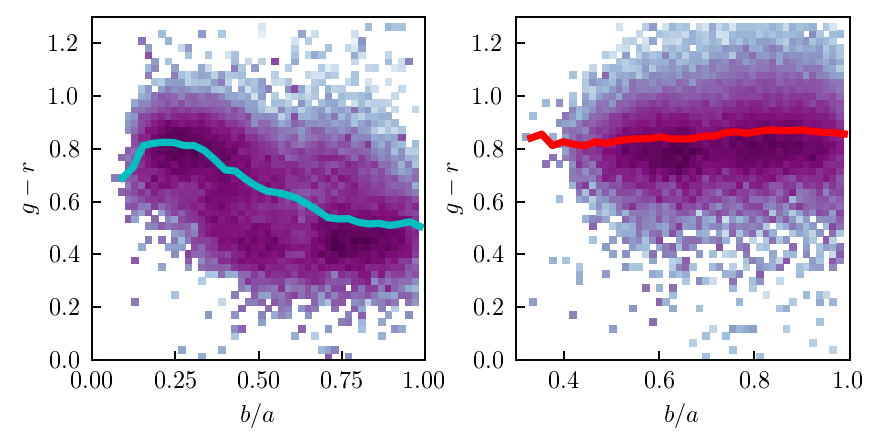

In [6]:
from code.plot_utils import plot_2d_dist

Mlim = -19.0; Dmax = 1000.
ipos = ((pEll<0) | (pS0<0) | (pSab<0) | (pScd<0))
iloc = ((Mmeert < Mlim) & (20. < d_Lm) & (d_Lm < Dmax) & 
        (pEll>=0) & (pS0>=0) & (pSab>=0) & (pScd>=0) )
grmloc = grm[iloc]; Mmloc  = Mmeert[iloc]; baloc = ba[iloc]
dLl = d_Lm[iloc]; vmaxiloc = vmaxim[iloc]
crloc = cr[iloc]; murloc= sb50[iloc]


Mrlim = [-24.,Mlim]; grlim = [0.,1.3];
crlim = [1.3,3.8]; sblim = [18., 23.]

fig, ax = plt.subplots(1,2,figsize=(5.0, 2.5))
fig.tight_layout()

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

ablim = [0.,1.]
indds = (((np.abs(pSab[iloc]) >0.7) | (np.abs(pScd[iloc]) > 0.7)) & 
         (baloc >= 0) & (grmloc>0))
indde = (((np.abs(pEll[iloc]) >0.7) | (np.abs(pS0[iloc]) > 0.7)) & 
         (baloc >= 0) & (grmloc>0))

plot_2d_dist(baloc[indds], grmloc[indds], ablim, grlim, weights=vmaxiloc[indds],  
             nxbins=51, nybins=51, 
             xlabel=r'$b/a$', ylabel=r'$g-r$', fig_setup=ax[0])

from scipy.stats import binned_statistic
cmed, ibedges, babins = binned_statistic(baloc[indds], grmloc[indds], 
                                         statistic='median', bins=30)
ibins = 0.5*(ibedges[1:] + ibedges[:-1])
ax[0].plot(ibins,cmed,c='c',lw=3.0)

plot_2d_dist(baloc[indde], grmloc[indde], xlim=[0.3,1], ylim=grlim, 
             weights=vmaxiloc[indde],  nxbins=51, nybins=51, 
             xlabel=r'$b/a$', ylabel=r'$g-r$', fig_setup=ax[1])
cmed, ibedges, babins = binned_statistic(baloc[indde], grmloc[indde], 
                                         statistic='median', bins=30)
ibins = 0.5*(ibedges[1:] + ibedges[:-1])
ax[1].plot(ibins, cmed, c='r', lw=3.0)

plt.savefig('fig/bagr_dust_meert.png', bbox_inches='tight')
plt.show()
plt.close(fig)

<img width=800 align=left src="fig/bagr_dust_meert.png"></img>

### Distribution of galaxy properties weighted by the morphology probability

First, let's plot diagrams of some properties for the entire galaxy sample. I am not applying k- and evolution corrections here because galaxies in this sample are almost all at $z<0.2$ and what's important here is qualitative features of how galaxies of different morphological types are distributied in the space of basic photometric parameters. 

C:\Users\h2_sf\Canopy2\User\lib\site-packages\matplotlib\contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


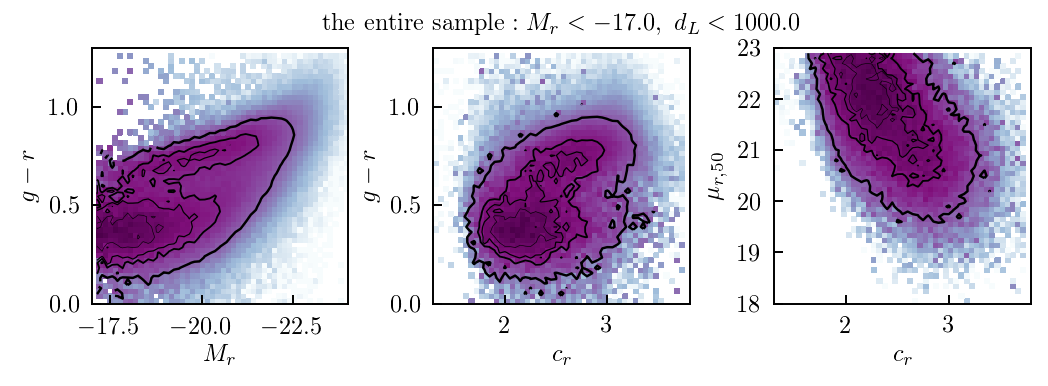

In [9]:
from code.plot_utils import plot_2d_dist

# select a sample of nearby SDSS galaxies down to a given luminosity to get reasonably detailed images
Mlim = -17.0; Dmax = 1000.
ipos = ((pEll<0) | (pS0<0) | (pSab<0) | (pScd<0))
iloc = ((Mmeert < Mlim) & (20. < d_Lm) & (d_Lm < Dmax) & 
        (pEll>=0) & (pS0>=0) & (pSab>=0) & (pScd>=0) )
grmloc = grm[iloc]; Mmloc  = Mmeert[iloc]; baloc = ba[iloc]
dLl = d_Lm[iloc]; vmaxiloc = vmaxim[iloc]
crloc = cr[iloc]; murloc= sb50[iloc]

Mrlim = [-24.,Mlim]; grlim = [0.,1.3];
crlim = [1.3,3.8]; sblim = [18., 23.]

clevs = np.linspace(0.2,0.95,4)

fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
fig.tight_layout()

plot_2d_dist(Mmloc, grmloc, Mrlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])

ax[1].set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)
plot_2d_dist(crloc, grmloc, crlim, grlim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])

plot_2d_dist(crloc, murloc, crlim, sblim,  weights=vmaxiloc, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])

plt.savefig('fig/colconcmu_meert.png',bbox_inches='tight')
plt.show()
plt.close(fig)

<img width=900 align=left src="fig/colconcmu_meert.png"></img>

Now explore these and other properties for galaxies as a function of a given morphological class

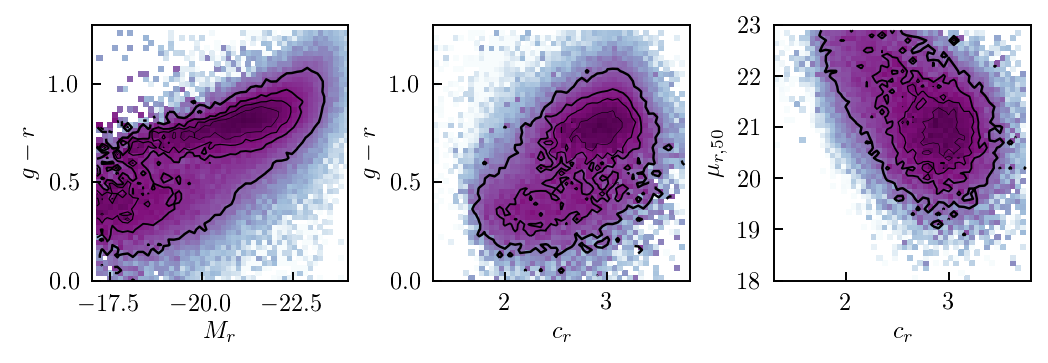

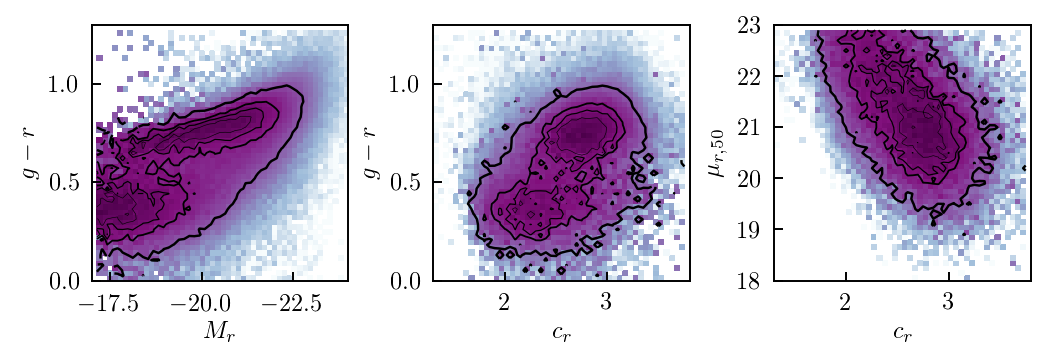

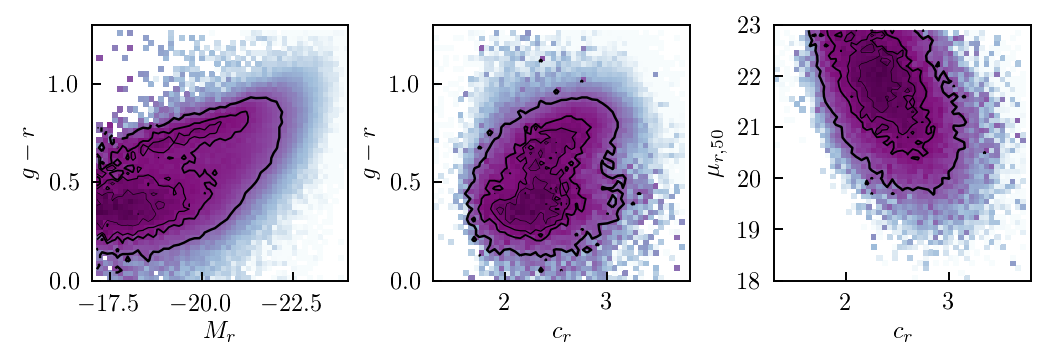

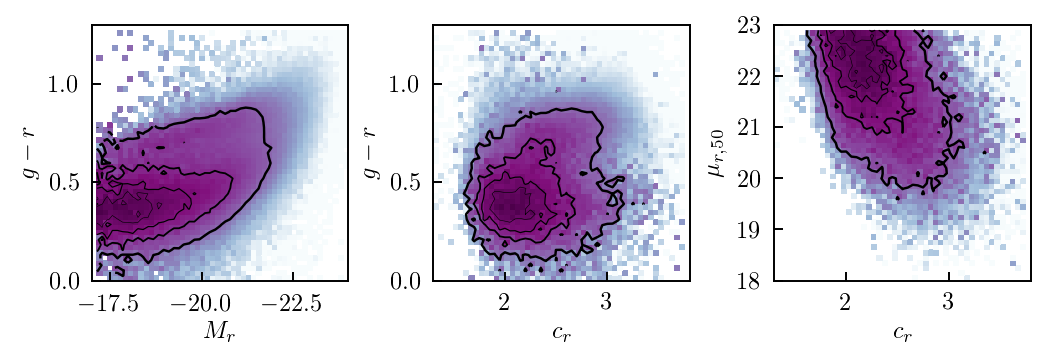

In [10]:
wEll = pEll[iloc]*vmaxiloc; wS0 = pS0[iloc]*vmaxiloc; 
wSab = pSab[iloc]*vmaxiloc; wScd = pScd[iloc]*vmaxiloc
Mrlim = [-24,Mlim]

for w_, clname in [[wEll,'Ell'], [wS0,'S0'], [wSab,'Sab'], [wScd,'Scd']]:
    fig, ax = plt.subplots(1,3,figsize=(6., 2.0))
    fig.tight_layout()

    plot_2d_dist(Mmloc, grmloc, Mrlim, grlim,  weights=w_, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$M_r$', ylabel=r'$g-r$', fig_setup=ax[0])

    plot_2d_dist(crloc, grmloc, crlim, grlim,  weights=w_, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$g-r$', fig_setup=ax[1])

    plot_2d_dist(crloc, murloc, crlim, sblim,  weights=w_, nxbins=51, nybins=51, clevs=clevs, 
             xlabel=r'$c_r$', ylabel=r'$\mu_{r,50}$', fig_setup=ax[2])
    plt.savefig('fig/colconcmu_%s.png'%clname,bbox_inches='tight')

    plt.show()
    plt.close(fig)



### Ellipticals

<img width=900 align=left src="fig/colconcmu_Ell.png"></img>

### S0s
<img width=900 align=left src="fig/colconcmu_S0.png"></img>

### Sab
<img width=900 align=left src="fig/colconcmu_Sab.png"></img>

### Scd
<img width=900 align=left src="fig/colconcmu_Scd.png"></img>

### Morphological classification using photometric properties of galaxies

Unlike what could be naively expected, the distribution of concentrations of disk galaxies spans a wide range and there is a "ridge" towards high concentrations. The origin of this ridge, as well as the contamination of the red sequence by edge-on disks, becomes clear when we plot, say, concentration as a function of axes ratio of light distribution.

C:\Users\h2_sf\Canopy2\User\lib\site-packages\matplotlib\axes\_base.py:1292: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Users\h2_sf\Canopy2\User\lib\site-packages\matplotlib\axes\_base.py:1297: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


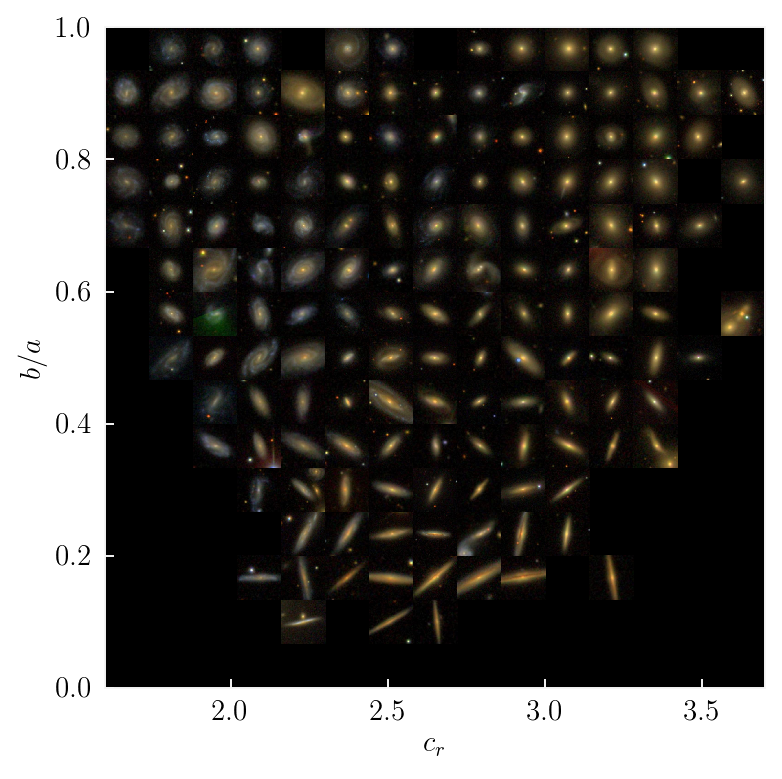

In [10]:
from code.plot_utils import plot_sdss_collage_with_2d_dist

Mlim = -20.
Dmin = 50.; Dmax = 200.
isel = (Mmeert < Mlim) & (d_Lm>Dmin) & (d_Lm < Dmax)

locdatas = sdata[isel]; locmdata = mdata[isel]
objs = locdatas['objid']; ras = locdatas['ra']; decs = locdatas['dec']
crs = cr[isel]; bas = locmdata['ba_tot']

xlabel = r'$c_r$'; ylabel = r'$b/a$'
nrows = 15; ncols = 15; rnd_seed = 3415926
ylims = [0.,1.]; xlims = [1.6,3.7]

clevs = np.linspace(0.2,0.95,4)

plt.rc('font',size=12)

d_A = d_Lm[isel]/np.square(1.0+locdatas['z'])

import matplotlib as mpl
mpl.rc('axes',edgecolor='w'); 

plot_sdss_collage_with_2d_dist(objs, ras, decs, xs=crs, ys=bas, xlims = xlims, ylims=ylims, 
                               xlab=xlabel, ylab=ylabel, 
                               show_axis=True, show_xaxis = True, show_yaxis=True, 
                               nrows=nrows, ncols=ncols, npix = 200, 
                               rnd_seed=rnd_seed, facecolor='black', kpc_per_npix = 30, dA = d_A, 
                               outfile='fig/crab_collage.png')
mpl.rc('axes',edgecolor='black'); 

<img width=900 align=left src="fig/crab_collage.png"></img>